### IMPORTING THE NECESSARY LIBRARIES

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from gtts import gTTS
import IPython.display as ipd

### PREPROCESSING THE DATASET

#### 1. Data Augmentation:   
    There are 50 samples of images in each letter folder which is not suffiecient for building a model. So, we done the augmentation on these generated datasets. 1950 images are generated by rotating the images upto 15 degrees, sheering and zooming upto 0.1% range and changing its brightness in between the range of 0.5 to 1.5. In each iteration of saving a letter, a text message of 'clear screen and redraw again' will appear on the screen.

In [2]:
image_directory = r"C:\Users\91813\Desktop\Mini Project 2023\Vattezhuthu Images"
image__size=(32,32)
batch__size=32
tr=0.7
vl=0.1
te=0.2

In [ ]:
#datagen = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=(0.5, 1.5))


#my_images = os.listdir(image_directory)

#for letter_folder in tqdm(os.listdir(image_directory)):
    letter_path = os.path.join(image_directory, letter_folder)
    dataset = []  # Initialize dataset for each letter folder

    for i, image_name in enumerate(os.listdir(letter_path)):
        if (image_name.split('.')[-1] == 'png'):
            image = io.imread(os.path.join(letter_path, image_name))
            image = Image.fromarray(image, 'RGB')
            dataset.append(np.array(image))

    x = np.array(dataset,dtype=object)
    i = 0

    for batch in datagen.flow(x, batch_size=40,
                              save_to_dir=letter_path,  # Save to the same letter folder
                              save_prefix='dr',
                              save_format='png'):
        i += 1
        if i > 50:
            break

#### 2. Read the dataset:               
   Reading the whole dataset using keras.preprocessing. The image size is converted to (32,32) and a batch of size 32 is created. Set the shuffle to be True so that the order of the images in the dataset will be randomized.

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
            image_directory,
            shuffle=True,
            image_size=image__size,
            batch_size=batch__size)

Found 57999 files belonging to 29 classes.


##### Analysing the dataset:

   class names of the dataset is called and converetd into lower case which helps in sound generation

In [4]:
class_names=dataset.class_names
#class_names=[names.lower()  for names in class_names if not names.startswith('.')]
class_names=[names.lower()  for names in class_names ]
class_names
#len(class_names)

['a',
 'aa',
 'ai',
 'ca',
 'e',
 'ee',
 'i',
 'ii',
 'ka',
 'la',
 'lla',
 'llla',
 'ma',
 'na',
 'nga',
 'nna',
 'nnna',
 'nya',
 'o',
 'oo',
 'pa',
 'ra',
 'rra',
 'ta',
 'tta',
 'u',
 'uu',
 'va',
 'ya']

Image batch represents a batch of images from the dataset. The dimension of the image batch is checked out. It is arranged in the form of (batch size, image height, image width, no of channels). Label_batch represents the corresponding labels associated with the batch of images. 'numpy()' is used to convert the tensor to a NumPy array so that it can be easily printed.

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
## image_size- no of images,size of images,size of images, channels
## label_batch-  folders in captured images

(32, 32, 32, 3)
[ 5  4 19 11 15 11 17  3  8 20  1 26 11 26  7 15 14 11 12  4 13 23 26 18
  1 26 28  6 19 15 25 28]


#### 3. Splitting the dataset into train, validation, test sets:

A function named 'get_dataset_partitions_tf' is created for splitting the dataset. Six parameters are given to the functions.( ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000) - These are the parameters of the function. Whenever calling this function, it needs a dataset ds and optionally specify values for the other parameters. If the function has no values for them, they will default to the values shown here. The function checks out whether the shuffle is set to True. If it is, it shuffles the dataset with 10000 elements and sets the random seed for reproducibilty to be 12 for getting same shuffled order of data in each running time. Then the splitting occurs using ds.take() and ds.skip() functions. Train data contains 70% of the whole dataset, validation contains 10% and test contains 20% of the dataset.

In [6]:
def get_dataset_partitions_tf(ds,train_split=tr,val_split=vl,
                           test_split=te,
                           shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)


    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

##### Caching and prefetching the each splitted datasets inorder to reduce its running time.

1. Caching: '.cache()' - This function call caches the elements of the dataset in memory or on disk, depending on available memory and the dataset size. Caching is used to speed up the training process by avoiding redundant data loading. It's especially helpful when working with large datasets that don't fit entirely in memory.
2. Prefetching: '.prefetch()' - This function call prefetches dataset elements to improve data loading performance. Prefetching overlaps data loading and model training, reducing the time the model spends waiting for data during training.

Ecah datasets are shuffled during caching and prefetching. Buffle size of 1000 is given for shuffling to improve the model's ability to generalize from the training data. In prefetching, 'buffer_size=tf.data.AUTOTUNE' is given to dynamically adjusts the prefetch buffer size based on available system resources.  

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Rescaling the image datasets:

 rescale variable defines a Sequential model consisting of a preprocessing layer: Rescaling. The Rescaling layer normalizes the pixel values to the [0, 1] range. This preprocessing steps is often essential when working with image data to ensure that the data is in a consistent and suitable format for neural network training.








In [9]:
rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

####  CREATING THE MODEL
The general Convolutional Neural Networks model is used here to recognize the letters of Vattezhuthu scripts.

In [10]:
input__shape=(32,32,32,3)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0.005,verbose=1)
vb=1
es=10
bs=32
save_model=r"C:\Users\91813\Desktop\Mini Project 2023\Saved Model\vattezhuthu.h5"
outputnum=len(class_names)

A sequential model is built with CNN for image classification using a model variable. The model has 2 convolutional layers for feature extractionwith 32 and 64 filters respectively and ReLu activation function. It takes 3-channel images as input. It then adds a max-pooling layers right after each convolutional layers to downsample feature maps. The model then has a flattening layer to convert 2D feature maps into a 1D vector. After flattening the layers, it adds 2 fully connected layers for high-level feature learning. One with 64 units and ReLu activation function and another output layer with 29 units ( number of classes) and softmax activation function for class probabilities. resize and rescale preprocessing steps prepare the input data for CNN layers. The model is designed to work with 32x32 RGB images and predict one of 29 classes.


In [11]:
model = models.Sequential([
    rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.build(input_shape=input__shape)

##### Analyzing the architecture of the model

This function provides a concise summary of the neural network model's architecture. It prints information about each layer in the model, including the layers name,type,output shape and the number of trainable parameters.  

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 32, 32, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 30, 30, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 15, 15, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 13, 13, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 6, 6, 64)            0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 2304)               

#### Compiling the model:

Compilation is used to configure the training process for a neural network model. It sets the optimizer as 'adam'. The optimizer is responsible for updating the model's weights during training to minimize the loss function. Adam is a popular optimization algorithm that adapts the learning rate during training for faster convergence. The model will use 'SparseCategoricalCrossentropy' as the loss function during training. It measures how well the model's predictions match the actual target values. It defines accuracy as the evaluation metrics. Accuracy measures the percentage of correctly classified examples in the training data.

In [13]:
model.compile(
optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

.fit() function is used to train a neural network model.It takes input data, labels, and various training parameters to optimize the model's weights and make it better at its task. The training dataset is given to train the model. The model learns from this dataset during training. Batch_size is set as 32 to determine how many examples are used in each update of the model's weights during training. The model is evaluated on validation dataset after each epoch (training cycle). It helps to monitor the model's performance on unseen data and detect overfitting.  Training for more epochs allows the model to learn better but may lead to overfitting if not controlled.  Callbacks are functions that are called at specific points during training.  Early stopping monitors the validation loss and stops training when it detects that the model's performance on the validation data is no longer improving. This helps prevent overfitting and saves training time.

In [14]:
history = model.fit(
    train_ds,
    batch_size=bs,
    validation_data=val_ds,
    verbose=vb,
    epochs=es,
    callbacks=early_stopping
)

Epoch 1/10
1269/1269 [==============================] - 106s 57ms/step - loss: 0.6209 - accuracy: 0.8176 - val_loss: 0.0941 - val_accuracy: 0.9709
Epoch 2/10
1269/1269 [==============================] - 43s 34ms/step - loss: 0.0609 - accuracy: 0.9810 - val_loss: 0.0560 - val_accuracy: 0.9799
Epoch 3/10
1269/1269 [==============================] - 42s 33ms/step - loss: 0.0337 - accuracy: 0.9889 - val_loss: 0.0161 - val_accuracy: 0.9955
Epoch 4/10
1269/1269 [==============================] - 42s 33ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0394 - val_accuracy: 0.9867
Epoch 5/10
1269/1269 [==============================] - 42s 33ms/step - loss: 0.0197 - accuracy: 0.9944 - val_loss: 0.0231 - val_accuracy: 0.9924
Epoch 6/10
1269/1269 [==============================] - 43s 34ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0151 - val_accuracy: 0.9969
Epoch 7/10
1269/1269 [==============================] - 43s 34ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0039 

Scores: Evaluating the model using test dataset. Evaluation involves running the test dataset through the model and calculating various metrics (such as loss and accuracy) to assess the model's performance on unseen data.


history: The history object typically contains information about the training process, including metrics like loss and accuracy over each epoch.

In [15]:
scores=model.evaluate(test_ds)
scores
history
history.params
history.history.keys()

363/363 [==============================] - 37s 14ms/step - loss: 0.0242 - accuracy: 0.9941


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

###### Analysing the accuracy and loss of training and validation dataset using the model built

1. Accuracy:  accuracy of the model on the training data at each epoch during training.
2. Validation accuracy:  accuracy of the model on a separate validation dataset at each epoch during training. This helps monitor how well the model generalizes to unseen data.
3. Loss: value of the loss function on the training data at each epoch during training. It indicates how well the model is fitting the training data.
4. Validation Loss:  value of the loss function on the validation dataset at each epoch during training. It helps you assess how well the model generalizes.

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

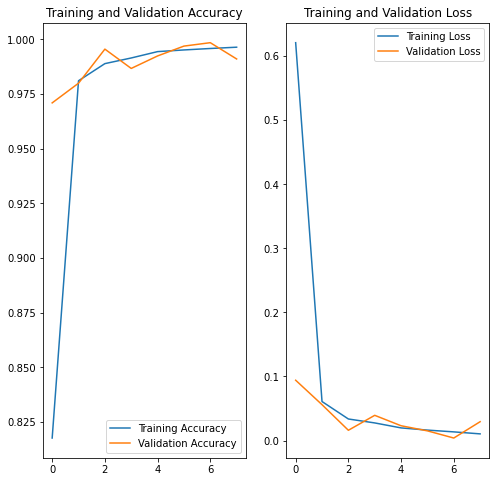

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(8), acc, label='Training Accuracy')
plt.plot(range(8), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(8), loss, label='Training Loss')
plt.plot(range(8), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### SAVING THE MODEL

model.save(): This is a method in TensorFlow's Keras API used to save a trained neural network model to disk. Saving a model allows one to store it in a file so that he/she can later load and reuse the model without having to retrain it.

In [19]:
model.save(save_model)

C:\Users\91813\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### LOADING THE MODEL

Loading a model allows one to retrieve the architecture and weights of the trained model for various purposes.

In [20]:
vattezhuthu_model=tf.keras.models.load_model(save_model)
vattezhuthu_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)             

#### CREATING A PREDICTION FUNCTION

A function named predict is defined with two arguments- model and img. The function first converts the image to numpy array and then adds an extra dimension to it to match the expected input shape of the model. Next,it uses the 'model' to make predictions on input image, and also print out its label name. It then calculates the confidence level of the prediction by taking the maximum probability in the predictions array and converting it to a percentage.


In [21]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


#### TESTING THE MODEL

##### Test the model with test dataset.

The code below creates a grid of subplots, displays images from the test dataset, and adds titles indicating the actual class, predicted class, and confidence score for each image in the batch. It's a way to visually inspect the model's predictions on the test data.
    

1/1 [==============================] - 0s 32ms/step


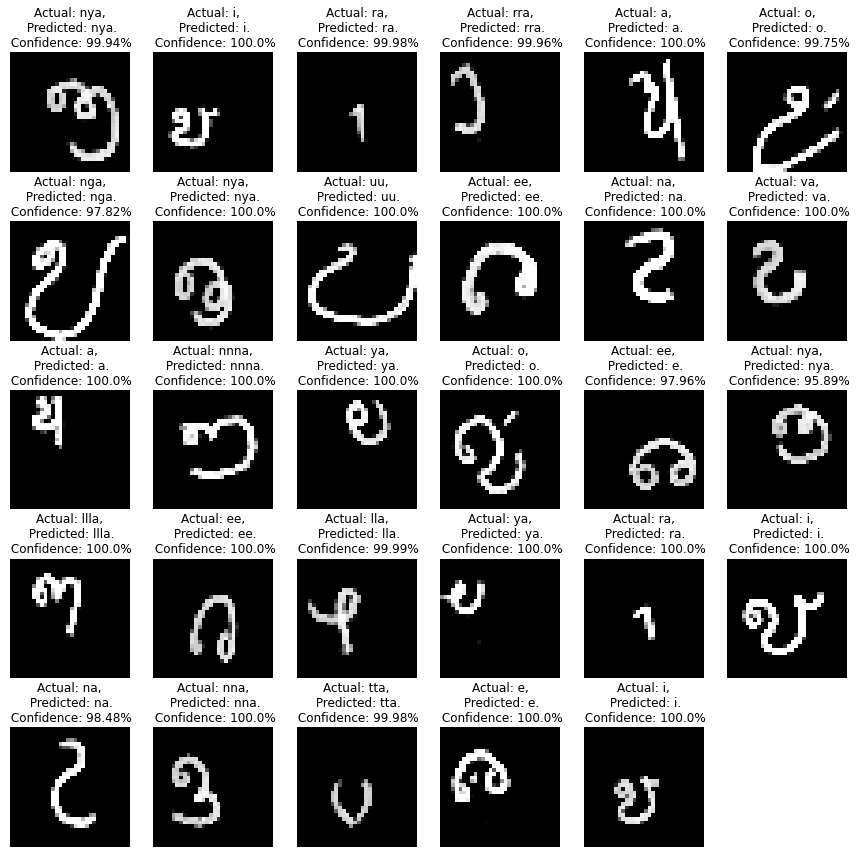

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(29):
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


This code snippet loads a batch of test images in the test dataset and their labels, predicts the label for the first image using a trained model, converts the predicted label to speech, saves it as an audio file, and then plays the audio for the predicted label.

first image to predict
actual label: nna
1/1 [==============================] - 0s 100ms/step
predicted label: nna


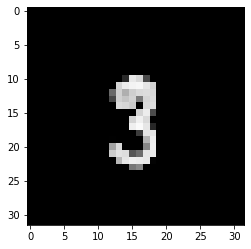

In [31]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    predicted_label=class_names[np.argmax(batch_prediction[0])]
    print("predicted label:",predicted_label)
    sound = gTTS(text=predicted_label, lang='en', slow=True)
    sound.save('vattezhuthu.mp3')
    os.system('start vattezhuthu.mp3')
    ipd.Audio('vattezhuthu.mp3')

##### Testing the model with external image

  Test image is loaded  and resized to (32,32) pixels, convert into NumPy array and then adds a batch dimension to prepare it for the prediction with deep learning model.

In [ ]:
test_image_path=r"C:\Users\91813\Desktop\Mini Project 2023\Test Image\0.png"

In [29]:
test_image = tf.keras.preprocessing.image.load_img(
    test_image_path,
    target_size=(32, 32)
)
test_image=tf.keras.preprocessing.image.img_to_array(test_image)
test_image = tf.expand_dims(test_image, axis=0)

In [30]:
# plt.imshow(test_image.numpy().astype('uint8'))
batch_prediction=model.predict(test_image)
predicted_label=class_names[np.argmax(batch_prediction)]
print("predicted label:",predicted_label)
sound = gTTS(text=predicted_label, lang='en', slow=True)
sound.save('vattezhuthu.mp3')
os.system('start vattezhuthu.mp3')
ipd.Audio('vattezhuthu.mp3')

1/1 [==============================] - 0s 47ms/step
predicted label: ka
